# Monet GAN Project

Intro here ...

In [1]:
import tensorflow as tf
tf.config.optimizer.set_jit(True)
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)
# TF_GPU_ALLOCATOR='cuda_malloc_async'

2025-11-11 19:27:55.911407: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 19:27:55.949530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 19:27:57.399021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import os
import glob
import random
import warnings
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras import layers

Tensorflow Hub  
https://www.tensorflow.org/tutorials/generative/style_transfer#fast_style_transfer_using_tf-hub  
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial  
https://machinelearningmastery.com/cyclegan-tutorial-with-keras/

## Data Summary

#### Data Source
- Data was imported from the 'I’m Something of a Painter Myself' Kaggle competition.
- 2 folders provided from Kaggle: monet_jpg and photo_jpg. These will be converted to Tensorflow record files so it's easier to do work with

Reference:  
Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.

#### Import Datasets

In [3]:
# Paths to data folders and labels file
monet_images_path = './monet_jpg/'
photos_images_path  = './photo_jpg/'

# Create a list of the file paths to the images in the monet and photos folders
monet_file_paths = glob.glob(os.path.join(monet_images_path, '*.jpg'))
photos_file_paths = glob.glob(os.path.join(photos_images_path, '*.jpg'))

print(f'Count of Monet paintings = {len(monet_file_paths):,}\nCount of photo images = {len(photos_file_paths):,}')

Count of Monet paintings = 300
Count of photo images = 7,038


#### Configure Constant Variables
- Define the exogenous varibles that will be used throughout the modeling and analysis.

In [4]:
# Set random seeds for reproducibility
tf.random.set_seed(666)
np.random.seed(666)

# # Image config
IMG_SIZE = 256 # Images dimensions (256 x 256 pixels)
CHANNELS = 3  # RGB images
# SAMPLE_SIZE = 55000 # Number of image samples used for training

# # Training config
BATCH_SIZE = 1 # Training batch size
# AUTOTUNE = tf.data.AUTOTUNE # Let tf.data choose parallelism
# MAX_EPOCHS = 30

# Ignore warnings
warnings.simplefilter('ignore')

## EDA

#### RBG Histogram Distributions
- ...

In [5]:
# # Function to create RGB histogram data
# def get_histogram_data(files):
#     hists = np.zeros((3, 255), dtype=np.float64)
#     for path in files:
#         img = cv2.imread(path, cv2.IMREAD_COLOR)
#         for ch in range(3):
#             hists[ch] += cv2.calcHist([img], [ch], None, [255], [1, 255]).ravel()
#     return hists

# # Get histogram data
# monet_files_hist_data = get_histogram_data(monet_file_paths)
# photos_files_hist_data = get_histogram_data(photos_file_paths)

# monet_files_probability_data = monet_files_hist_data / monet_files_hist_data.sum(axis=1, keepdims=True)
# photos_files_probability_data = photos_files_hist_data / photos_files_hist_data.sum(axis=1, keepdims=True)

# # Plot RGB Histograms
# fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,5), sharey=True, sharex=True)

# ax0.plot(monet_files_probability_data[0], 'b', label='Blue')
# ax0.plot(monet_files_probability_data[1], 'g', label='Green')
# ax0.plot(monet_files_probability_data[2], 'r', label='Red')
# ax0.set_title('Monet Paintings', fontdict={'fontsize':10})
# ax0.set_xlabel('Pixel Intensity (0–256)')
# ax0.set_ylabel('Density')
# ax0.grid(True, alpha=0.3)

# ax1.plot(photos_files_probability_data[0], 'b', label='Blue')
# ax1.plot(photos_files_probability_data[1], 'g', label='Green')
# ax1.plot(photos_files_probability_data[2], 'r', label='Red')
# ax1.set_title('Photos', fontdict={'fontsize':10})
# ax1.set_xlabel('Pixel Intensity (0–256)')
# ax1.grid(True, alpha=0.3)
# ax1.legend()

# plt.suptitle(f'Aggregated RGB Histograms')
# plt.tight_layout()
# plt.show()

#### Similar Looking Pictures  
- ...

In [6]:
# # Function to plot similar photos based on color histogram similarity
# def plot_similar_photos(monet_file_paths, photos_file_paths):

#     # Function to compute color histogram
#     def compute_histogram(image_path):
#         image = cv2.imread(image_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
#         cv2.normalize(hist, hist)
#         return hist.flatten()

#     # Select 10 random Monet paintings
#     random_monet_paths = random.sample(monet_file_paths, 10)

#     for monet_path in random_monet_paths:
#         monet_hist = compute_histogram(monet_path)
#         similarities = []
#         for photo_path in photos_file_paths:
#             photo_hist = compute_histogram(photo_path)
#             correlation = cv2.compareHist(monet_hist, photo_hist, cv2.HISTCMP_CORREL)
#             similarities.append((photo_path, correlation))

#         # Sort photos by similarity (correlation) in descending order
#         similarities.sort(key=lambda x: x[1], reverse=True)
#         top_similar_photos = similarities[:5]

#         # Plotting
#         plt.figure(figsize=(15, 5))
#         monet_image = cv2.imread(monet_path)
#         monet_image = cv2.cvtColor(monet_image, cv2.COLOR_BGR2RGB)
#         plt.subplot(1, 6, 1)
#         plt.imshow(monet_image)
#         plt.axis('off')
#         plt.title('Monet Painting')

#         for i, (photo_path, corr) in enumerate(top_similar_photos):
#             photo_image = cv2.imread(photo_path)
#             photo_image = cv2.cvtColor(photo_image, cv2.COLOR_BGR2RGB)
#             plt.subplot(1, 6, i + 2)
#             plt.imshow(photo_image)
#             plt.axis('off')
#             plt.title(f'Corr: {corr:.2f}')

#         plt.tight_layout()
#         plt.show()


# plot_similar_photos(monet_file_paths, photos_file_paths)

#### Create Training, Validation, and Test Datasets
- ...

In [7]:
# Numpy function used to read and resize images
def _read_and_resize(path):
    path = path.decode('utf-8')
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return img.numpy()

#Function to load and preprocess each image
def load_image(path):
    img = tf.numpy_function(_read_and_resize, [path], tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, CHANNELS])
    img = (img / 127.5) - 1.0
    return img

# Create training dataset
monet_ds = (
    tf.data.Dataset.from_tensor_slices(monet_file_paths)
    .shuffle(len(monet_file_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nMonet dataset of {len(monet_file_paths):,} paintings has been created.')

# Create validation dataset
photos_ds = (
    tf.data.Dataset.from_tensor_slices(photos_file_paths)
    .shuffle(len(photos_file_paths))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
print(f'\nPhotos dataset of {len(photos_file_paths):,} images has been created.')

train_ds = tf.data.Dataset.zip((photos_ds, monet_ds))

I0000 00:00:1762914479.592004    5522 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



Monet dataset of 300 paintings has been created.

Photos dataset of 7,038 images has been created.


#### Plan of Analysis
- ...

## Modeling

#### Generator

In [8]:
# GENERATOR

def resnet_block(x, filters):
    y = layers.Conv2D(filters, (3, 3), padding='same')(x)
    y = layers.GroupNormalization(groups=1, axis=-1)(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(filters, (3, 3), padding='same')(y)
    y = layers.GroupNormalization(groups=1, axis=-1)(y)
    return layers.add([x, y])

def build_generator(image_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), n_res_blocks=6, name='generator'):
    inputs = layers.Input(shape=image_shape)
    x = layers.Conv2D(64, (7, 7), padding='same')(inputs)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)
    for _ in range(n_res_blocks):
        x = resnet_block(x, 256)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.Activation('relu')(x)
    outputs = layers.Conv2D(3, (7, 7), padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs, outputs, name=name)

#### Discriminator

In [9]:
# DISCRIMINATOR

def build_discriminator(image_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name='discriminator'):
    inputs = layers.Input(shape=image_shape)
    x = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, (4, 4), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(256, (4, 4), strides=2, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512, (4, 4), strides=1, padding='same')(x)
    x = layers.GroupNormalization(groups=1, axis=-1)(x)
    x = layers.LeakyReLU(0.2)(x)
    outputs = layers.Conv2D(1, (4, 4), strides=1, padding='same')(x)
    return tf.keras.Model(inputs, outputs, name=name)

In [10]:
class CycleGAN(tf.keras.Model):
    def __init__(self, G, F, D_x, D_y, lambda_cycle=10.0, lambda_identity=0.5):
        super().__init__()
        self.G = G
        self.F = F
        self.D_x = D_x
        self.D_y = D_y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity
        self.loss_obj = tf.keras.losses.MeanSquaredError()

    def compile(self, g_optimizer, f_optimizer, dx_optimizer, dy_optimizer):
        super().compile()
        self.g_optimizer = g_optimizer
        self.f_optimizer = f_optimizer
        self.dx_optimizer = dx_optimizer
        self.dy_optimizer = dy_optimizer
        self.g_adv_loss_metric = tf.keras.metrics.Mean(name="g_adv_loss")
        self.f_adv_loss_metric = tf.keras.metrics.Mean(name="f_adv_loss")
        self.dx_loss_metric = tf.keras.metrics.Mean(name="dx_loss")
        self.dy_loss_metric = tf.keras.metrics.Mean(name="dy_loss")
        self.cycle_loss_metric = tf.keras.metrics.Mean(name="cycle_loss")
        self.id_loss_metric = tf.keras.metrics.Mean(name="id_loss")

    def generator_loss(self, disc_pred):
        return self.loss_obj(tf.ones_like(disc_pred), disc_pred)

    def discriminator_loss(self, real, fake):
        real_loss = self.loss_obj(tf.ones_like(real), real)
        fake_loss = self.loss_obj(tf.zeros_like(fake), fake)
        return (real_loss + fake_loss) * 0.5

    def cycle_consistency_loss(self, real_x, real_y, cycled_x, cycled_y):
        loss_x = tf.reduce_mean(tf.abs(real_x - cycled_x))
        loss_y = tf.reduce_mean(tf.abs(real_y - cycled_y))
        return (loss_x + loss_y) * self.lambda_cycle

    def identity_loss(self, real_x, real_y, same_x, same_y):
        loss_x = tf.reduce_mean(tf.abs(real_x - same_x))
        loss_y = tf.reduce_mean(tf.abs(real_y - same_y))
        return (loss_x + loss_y) * self.lambda_cycle * self.lambda_identity

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.G(real_x, training=True)
            cycled_x = self.F(fake_y, training=True)

            fake_x = self.F(real_y, training=True)
            cycled_y = self.G(fake_x, training=True)

            same_x = self.F(real_x, training=True)
            same_y = self.G(real_y, training=True)

            disc_real_x = self.D_x(real_x, training=True)
            disc_fake_x = self.D_x(fake_x, training=True)

            disc_real_y = self.D_y(real_y, training=True)
            disc_fake_y = self.D_y(fake_y, training=True)

            g_adv_loss = self.generator_loss(disc_fake_y)
            f_adv_loss = self.generator_loss(disc_fake_x)
            total_cycle_loss = self.cycle_consistency_loss(real_x, real_y, cycled_x, cycled_y)
            id_loss = self.identity_loss(real_x, real_y, same_x, same_y)

            total_g_loss = g_adv_loss + total_cycle_loss + id_loss
            total_f_loss = f_adv_loss + total_cycle_loss + id_loss

            dx_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
            dy_loss = self.discriminator_loss(disc_real_y, disc_fake_y)

        g_grads = tape.gradient(total_g_loss, self.G.trainable_variables)
        f_grads = tape.gradient(total_f_loss, self.F.trainable_variables)
        dx_grads = tape.gradient(dx_loss, self.D_x.trainable_variables)
        dy_grads = tape.gradient(dy_loss, self.D_y.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grads, self.G.trainable_variables))
        self.f_optimizer.apply_gradients(zip(f_grads, self.F.trainable_variables))
        self.dx_optimizer.apply_gradients(zip(dx_grads, self.D_x.trainable_variables))
        self.dy_optimizer.apply_gradients(zip(dy_grads, self.D_y.trainable_variables))

        self.g_adv_loss_metric.update_state(g_adv_loss)
        self.f_adv_loss_metric.update_state(f_adv_loss)
        self.dx_loss_metric.update_state(dx_loss)
        self.dy_loss_metric.update_state(dy_loss)
        self.cycle_loss_metric.update_state(total_cycle_loss)
        self.id_loss_metric.update_state(id_loss)

        return {
            "g_adv_loss": self.g_adv_loss_metric.result(),
            "f_adv_loss": self.f_adv_loss_metric.result(),
            "dx_loss": self.dx_loss_metric.result(),
            "dy_loss": self.dy_loss_metric.result(),
            "cycle_loss": self.cycle_loss_metric.result(),
            "id_loss": self.id_loss_metric.result(),
        }

In [11]:
# Visualize base model metrics
def plot_history(h):
    for k, v in h.history.items():
        plt.plot(v, label=k)
    plt.legend()
    plt.title("CycleGAN training metrics")
    plt.show()

In [12]:
# G_photo2monet = build_generator()
# F_monet2photo = build_generator()
# D_photo = build_discriminator()
# D_monet = build_discriminator()

# cyclegan = CycleGAN(
#     G=G_photo2monet,
#     F=F_monet2photo,
#     D_x=D_photo,
#     D_y=D_monet,
#     lambda_cycle=10.0,
#     lambda_identity=0.5
# )

# lr = 2e-4
# opt = lambda: tf.keras.optimizers.Adam(lr, beta_1=0.5)

# cyclegan.compile(
#     g_optimizer=opt(),
#     f_optimizer=opt(),
#     dx_optimizer=opt(),
#     dy_optimizer=opt(),
# )

# history = cyclegan.fit(
#     train_ds,
#     epochs=2,
#     steps_per_epoch=1
# )

# plot_history(history)

# del cyclegan
# tf.keras.backend.clear_session()
# gc.collect()

In [21]:
# Visual inspection (Photo -> Monet)
def denormalize(img):
    return (img + 1.0) / 2.0

def show_photo_to_monet(model, photos_dataset, num_images=1):
    for photos in photos_dataset.take(3):
        fake_monets = model(photos, training=False)
        photos = denormalize(photos.numpy())
        fake_monets = denormalize(fake_monets.numpy())
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(7, 7))
        for i in range(num_images):
            # original
            # ax1 = plt.subplot(2, num_images, i+1)
            ax1.imshow(photos[i])
            ax1.axis('off')
            ax1.set_title('Original Photo')
            # generated
            # ax2 = plt.subplot(2, num_images, i+1+num_images)
            ax2.imshow(fake_monets[i])
            ax2.axis('off')
            ax2.set_title('Monet-style')
    plt.show()

# show_photo_to_monet(G_photo2monet, photos_ds)
# show_photo_to_monet(G_unet, photos_ds)

## Hyperparameter Tuning

In [14]:
# # Hyperparameter tuning loop
# tuning_configs = [
#     {"lr": 2e-4, "lambda_cycle": 10.0, "lambda_id": 0.5},
#     {"lr": 1e-4, "lambda_cycle": 10.0, "lambda_id": 0.5},
#     {"lr": 2e-4, "lambda_cycle": 5.0,  "lambda_id": 0.5},
# ]

# tuned_histories = []

# for cfg in tuning_configs:
#     print(f"\n--- Training with config: {cfg} ---")
#     G_t = build_generator(name='G_photo2monet_tuned')
#     F_t = build_generator(name='F_monet2photo_tuned')
#     D_x_t = build_discriminator(name='D_photo_tuned')
#     D_y_t = build_discriminator(name='D_monet_tuned')
#     cg_t = CycleGAN(
#         G=G_t, F=F_t,
#         D_x=D_x_t, D_y=D_y_t,
#         lambda_cycle=cfg["lambda_cycle"],
#         lambda_identity=cfg["lambda_id"]
#     )
#     opt = lambda: tf.keras.optimizers.Adam(cfg["lr"], beta_1=0.5)
#     cg_t.compile(
#         g_optimizer=opt(),
#         f_optimizer=opt(),
#         dx_optimizer=opt(),
#         dy_optimizer=opt(),
#     )
#     h = cg_t.fit(
#         train_ds,
#         epochs=3,
#         steps_per_epoch=3,
#         verbose=1
#     )
#     tuned_histories.append((cfg, h))

# # visualize each run
# for cfg, h in tuned_histories:
#     print(f"Config: {cfg}")
#     plot_history(h)

In [15]:
# # Generate Monet style images
# output_dir = './generated_monet_style/'
# os.makedirs(output_dir, exist_ok=True)

# counter = 0
# for batch in photos_ds:
#     fake = G_photo2monet(batch, training=False)
#     fake = denormalize(fake).numpy()  # [0,1]
#     for img in fake:
#         img_uint8 = (img * 255).astype(np.uint8)
#         tf.keras.utils.save_img(os.path.join(output_dir, f"monet_{counter:05d}.jpg"), img_uint8)
#         counter += 1
#         if counter >= 10000:   # stop at 10k
#             break
#     if counter >= 10000:
#         break
# print(f"Saved {counter} Monet-style images.")

## Other Models

Epoch 1/1000


2025-11-11 19:28:07.320185: I external/local_xla/xla/service/service.cc:163] XLA service 0x78b9dc005330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-11 19:28:07.320221: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-11-11 19:28:07.326346: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
I0000 00:00:1762914487.375160    5707 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-11 19:28:14.423476: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-11 19:28:18.539904: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. Th

300/300 ━━━━━━━━━━━━━━━━━━━━ 58s 102ms/step - cycle_loss: 4.2431 - dx_loss: 0.5769 - dy_loss: 0.5655 - f_adv_loss: 0.6940 - g_adv_loss: 0.6718 - id_loss: 1.9092
Epoch 2/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - cycle_loss: 2.2424 - dx_loss: 0.2543 - dy_loss: 0.2406 - f_adv_loss: 0.3310 - g_adv_loss: 0.4024 - id_loss: 0.9534
Epoch 3/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 36s 121ms/step - cycle_loss: 1.8823 - dx_loss: 0.2352 - dy_loss: 0.2183 - f_adv_loss: 0.3525 - g_adv_loss: 0.4161 - id_loss: 0.7886
Epoch 4/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - cycle_loss: 1.6057 - dx_loss: 0.2295 - dy_loss: 0.2115 - f_adv_loss: 0.3602 - g_adv_loss: 0.4265 - id_loss: 0.6621
Epoch 5/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 99ms/step - cycle_loss: 1.4704 - dx_loss: 0.2271 - dy_loss: 0.2128 - f_adv_loss: 0.3680 - g_adv_loss: 0.4156 - id_loss: 0.5939
Epoch 6/1000
300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 100ms/step - cycle_loss: 1.3336 - dx_loss: 0.2170 - dy_loss: 0.2052 - f_adv_loss: 0.3870 - g_adv_l

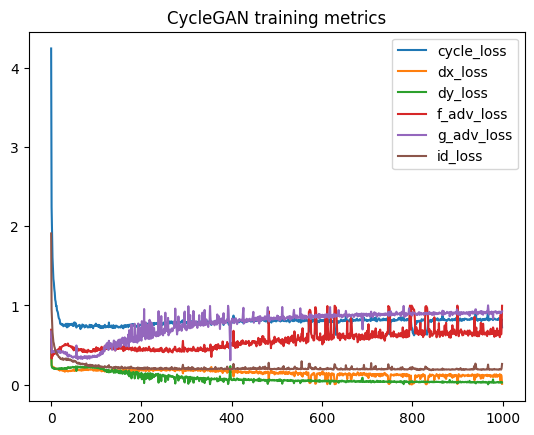

2025-11-12 07:57:02.189064: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


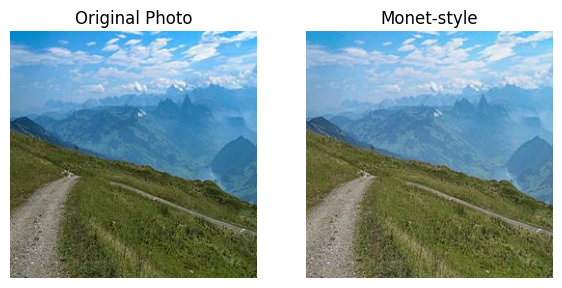

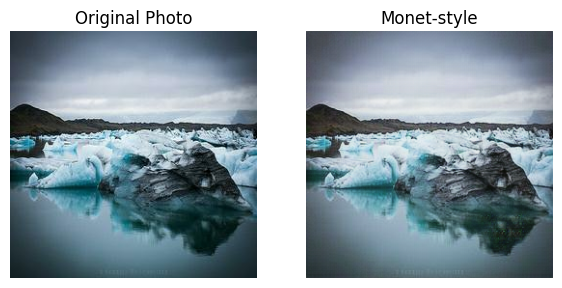

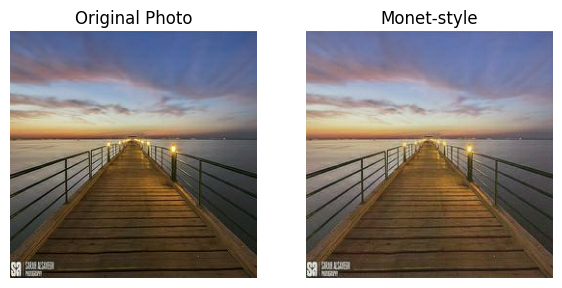

In [16]:
def build_unet_generator(image_shape=(IMG_SIZE, IMG_SIZE, CHANNELS), name='unet_generator'):
    inputs = layers.Input(shape=image_shape)

    # encoder
    d1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    d1 = layers.LeakyReLU(0.2)(d1)

    d2 = layers.Conv2D(128, 4, strides=2, padding='same')(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.LeakyReLU(0.2)(d2)

    d3 = layers.Conv2D(256, 4, strides=2, padding='same')(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.LeakyReLU(0.2)(d3)

    d4 = layers.Conv2D(512, 4, strides=2, padding='same')(d3)
    d4 = layers.BatchNormalization()(d4)
    d4 = layers.LeakyReLU(0.2)(d4)

    # decoder with skip connections
    u1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(d4)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.Activation('relu')(u1)
    u1 = layers.Concatenate()([u1, d3])

    u2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(u1)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.Activation('relu')(u2)
    u2 = layers.Concatenate()([u2, d2])

    u3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(u2)
    u3 = layers.BatchNormalization()(u3)
    u3 = layers.Activation('relu')(u3)
    u3 = layers.Concatenate()([u3, d1])

    u4 = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(u3)

    return tf.keras.Model(inputs, u4, name=name)

G_unet = build_unet_generator(name='G_photo2monet_unet')
F_unet = build_unet_generator(name='F_monet2photo_unet')
alt_cyclegan = CycleGAN(G_unet, F_unet, build_discriminator(), build_discriminator())
alt_cyclegan.compile(
    g_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    f_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    dx_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    dy_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
)
alt_history = alt_cyclegan.fit(train_ds, epochs=1000, steps_per_epoch=300)
plot_history(alt_history)
show_photo_to_monet(G_unet, photos_ds)

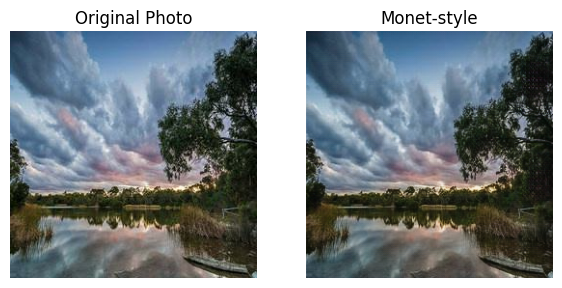

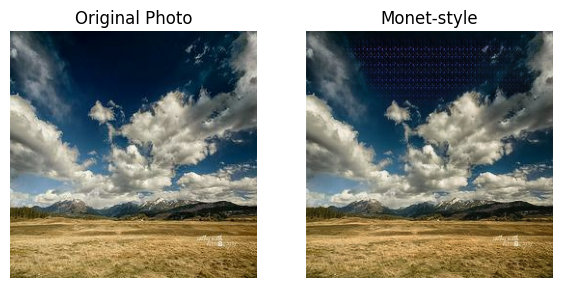

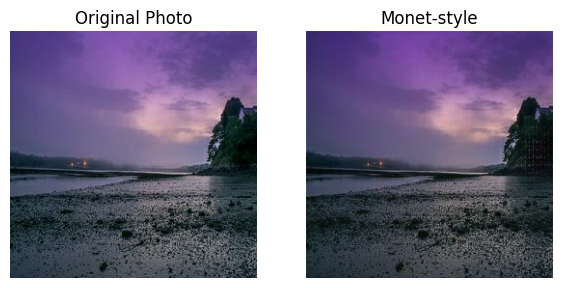

In [24]:
show_photo_to_monet(F_unet, photos_ds)

In [ ]:
import sys

print(f'Memory used by clones: {sys.getsizeof(gpus):.2f} B')

In [ ]:
del alt_cyclegan
del alt_history
tf.keras.backend.clear_session()
gc.enable()
gc.collect(0)
gc.collect(1)
gc.collect(2)

## Results & Analysis

## Conclusion